In [1]:
# basics code from https://www.kaggle.com/abdelrhmanhosny/brain-tumor-classification/notebook
import numpy as np # linear algebra
print('numpy: {}'.format(np.__version__))
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
print('pandas: {}'.format(pd.__version__))
import matplotlib.pyplot as plt
import os
from os.path import join
import sys
from sklearn.model_selection import train_test_split
# pytorch model

import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset

# pyTorch Lightning

import pytorch_lightning as pl
from torchmetrics import Accuracy

# image processing

from skimage.io import imread
from scipy.ndimage import zoom # image resizing 3D
from skimage.transform import resize
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import tensorflow as tf
print('tensorflow: {}'.format(tf.__version__))
from tensorflow import keras
import seaborn as sns

import re

numpy: 1.21.2
pandas: 1.3.4
tensorflow: 2.6.0


<AxesSubplot:xlabel='value', ylabel='count'>

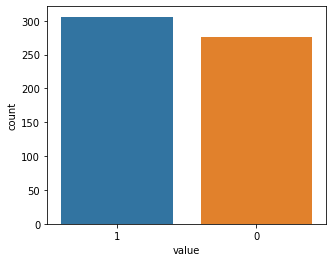

In [2]:
#open the training labels data 
df = pd.read_csv("E:\\Proj_data/train_labels.csv", header=0, names=['id','value'], dtype=object)
exclude_cases = ["00109", "00123", "00709"] #according to description
df = df[~df.id.isin(exclude_cases)]
df.head()

# values distribution
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x="value")

In [3]:
#create output dataset folders
os.makedirs('./train', exist_ok = True)
print('Train folder created')

os.makedirs('./validation', exist_ok = True)
print('Validation folder created')

Train folder created
Validation folder created


In [8]:
import zipfile
from zipfile import Path

#extraire une seule slice du milieu pour commencer cad une seule image des dossiers   
filepath = 'E:\\Proj_data/train.zip'
with zipfile.ZipFile(filepath, 'r') as zfile:
    #zfile.printdir()
    data = zfile.open('00009/T1wCE/Image-150.dcm')  #test
    data2 = zfile.open('00002/T1wCE/Image-50.dcm')  #test
    
    data_array = []
    length = 10
    
    n_list = []
    
    def get_list(p3) :  #get a list with the number of images inside our file
        string1 = p3[1]
        n = int(re.search(r'\d+', string1).group()) #gives the number part of the name file (ex: gets 20 from Image-20)
        n_list.append(n)
        return n_list

    def get_path(n_list): #creates an image path for the middle slice of our file 
        n_max=len(n_list) 
        print('len=', n_max)
        n2 = int(n_max/2)
        endpath = f'Image-{n2}.dcm'
        print('endpath=', endpath)
        return endpath
    
    for file in zfile.namelist() :  #pb: on prend image par image donc boucle counter ne fonctionne pas correctement  
        p1 = os.path.split(file) 
        p2 = os.path.split(p1[0])
        p3 = os.path.split(p1[1]) 
        m=0
        type1 = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
        
        for counter in range(3): #get the images from the 3 first FLAIR files, works if we put range(1) meaning only for the file 0000 for now  
            try:
                dossier = f'0{str(counter).zfill(4)}' #file 00001 doesnt exist (same for other ones)
                type_im =type1[m]
                if (p2[0]==dossier and p2[1]==type_im) :
                    n_list = get_list(p3)
            except :  #(p2[0]!=dossier) if the file doesnt exist, we go to the next one --> this doesnt work, we dont get an error message if the file doesnt exist  
                counter+=1
    
    endpath=get_path(n_list)
    
    for file in zfile.namelist() : 
        p1 = os.path.split(file)
        p2 = os.path.split(p1[0])
        p3 = os.path.split(p1[1])
        if (p3[1]==endpath and p2[0]==dossier and p2[1]==type_im) :   #if we have the right image, we add it to our data list
            data_array.append(file)
            print('okkkk')
  
    for i in range(10) : #display 10 images from our data list, we get list index out of range which is normal since the list is empty 
        print(data_array)
        data3 = zfile.open(data_array[i])
        ds3 = dicom.dcmread(data3)
        plt.imshow(ds3.pixel_array, cmap=plt.cm.bone)  # set the color map to bone
        plt.show()
        
#ds = dicom.dcmread(data)
#ds2 = dicom.dcmread(data2)

  
#plt.imshow(ds.pixel_array, cmap=plt.cm.bone)  # set the color map to bone
#plt.show()
  
#plt.imshow(ds2.pixel_array, cmap=plt.cm.bone)  # set the color map to bone
#plt.show()


len= 529
endpath= Image-264.dcm
[]


IndexError: list index out of range

In [13]:
#to convert the image format 
#doesnt work anymore ??

#fabriquer base de donnée plus petite
data_array.append('./train/00071_T1wCE_Image-51.dcm')
with zipfile.ZipFile(filepath, 'r') as zfile:
    for i in range(200) :
        if (data_array==[]) :
            print('Empty list')
            break
        else :
            for j in range(len(data_array)):  #reussir a sortir chaque filepath de la list
                if 'FLAIR' in data_array[j] :  #garder juste les image de flair pour commencer  
                    data = zfile.open(data_array[j])
                    print(data)
                    ds = dicom.dcmread(data)
                    image_path = file  ##+ data_array[j] #'./train/00071_T1wCE_Image-51.dcm'
                    pixel_array_numpy = ds.pixel_array
                    print(pixel_array_numpy)
                    print(type(pixel_array_numpy))
 
                    image_format = '.png'
                    image_path = image_path.replace('.dcm', image_format) #convertir type d'image de dcm en png

                    plt.imsave(image_path, pixel_array_numpy)